In [1]:
# Cell 1: Import required libraries
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import (Dense, Conv2D, MaxPooling2D, Flatten, Input,
                          RandomFlip, RandomRotation)
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix


In [3]:
# Set correct paths to your dataset
metadata_path = 'HAM10000_metadata.csv'
image_folder_1 = 'HAM10000_images_part_1'
image_folder_2 = 'HAM10000_images_part_2'

# Check if the files and folders are being accessed correctly
import os

print("Metadata exists:", os.path.exists(metadata_path))
print("Part 1 folder exists:", os.path.exists(image_folder_1))
print("Part 2 folder exists:", os.path.exists(image_folder_2))


Metadata exists: True
Part 1 folder exists: True
Part 2 folder exists: True


In [ ]:
#load and link data

import pandas as pd
import os

# Load metadata CSV
df = pd.read_csv('HAM10000_metadata.csv')

# Combine the two image folders
image_folder_1 = 'HAM10000_images_part_1'
image_folder_2 = 'HAM10000_images_part_2'

# Create a dictionary of all image paths
image_paths = {}
for folder in [image_folder_1, image_folder_2]:
    for img_name in os.listdir(folder):
        if img_name.endswith('.jpg'):
            image_paths[img_name] = os.path.join(folder, img_name)

# Add full image path to metadata
df['image_path'] = df['image_id'].map(lambda x: image_paths.get(x + '.jpg'))

# Check if any paths are missing
missing = df['image_path'].isnull().sum()
print(f"Missing image paths: {missing}")

# Show the first few rows to confirm
df.head()


Missing image paths: 0


,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0027419.jpg
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025030.jpg
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0026769.jpg
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,HAM10000_images_part_1/ISIC_0025661.jpg
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,HAM10000_images_part_2/ISIC_0031633.jpg


In [ ]:
#pre-process image and encode labels

import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm

# Image parameters
img_size = 100  # Resize all images to 100x100

# Load and resize images
images = []
for img_path in tqdm(df['image_path']):
    img = load_img(img_path, target_size=(img_size, img_size))
    img_array = img_to_array(img)
    images.append(img_array)

X = np.array(images) / 255.0  # Normalize pixel values

# Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['dx'])
y = to_categorical(y_encoded)

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


100%|██████████| 10015/10015 [01:04<00:00, 154.38it/s]


X shape: (10015, 100, 100, 3)
y shape: (10015, 7)


In [ ]:
#train-test split

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")


Train samples: 8012, Test samples: 2003


In [ ]:
#define CNN model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(2,2),
    
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,679 (6.61 MB)

 Trainable params: 1,732,679 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.8076 - loss: 0.5043 - val_accuracy: 0.7718 - val_loss: 0.6904
Epoch 2/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 29s 129ms/step - accuracy: 0.8152 - loss: 0.4703 - val_accuracy: 0.7656 - val_loss: 0.7030
Epoch 3/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.8133 - loss: 0.4832 - val_accuracy: 0.7706 - val_loss: 0.6686
Epoch 4/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 125ms/step - accuracy: 0.8333 - loss: 0.4262 - val_accuracy: 0.7693 - val_loss: 0.6854
Epoch 5/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.8425 - loss: 0.4182 - val_accuracy: 0.7768 - val_loss: 0.7381
Epoch 6/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.8373 - loss: 0.4130 - val_accuracy: 0.7706 - val_loss: 0.7305
Epoch 7/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.8552 - loss: 0.3697 - val_accuracy: 0.7793 - val_loss: 0.7372
Epoch 8/30
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 123ms/step - accuracy: 0.8632 - loss: 0

In [11]:
#evaluate model on test set

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.7526 - loss: 0.7318
Test accuracy: 0.7624, Test loss: 0.7133


63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step


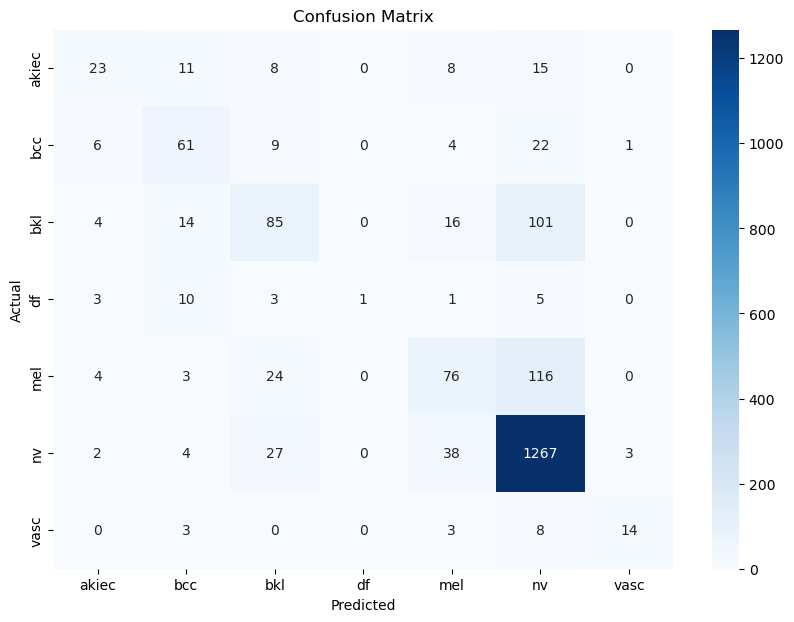

              precision    recall  f1-score   support

       akiec       0.55      0.35      0.43        65
         bcc       0.58      0.59      0.58       103
         bkl       0.54      0.39      0.45       220
          df       1.00      0.04      0.08        23
         mel       0.52      0.34      0.41       223
          nv       0.83      0.94      0.88      1341
        vasc       0.78      0.50      0.61        28

    accuracy                           0.76      2003
   macro avg       0.68      0.45      0.49      2003
weighted avg       0.74      0.76      0.74      2003



In [12]:
#confusion matrix

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


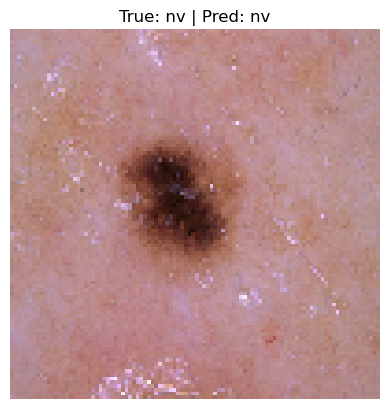

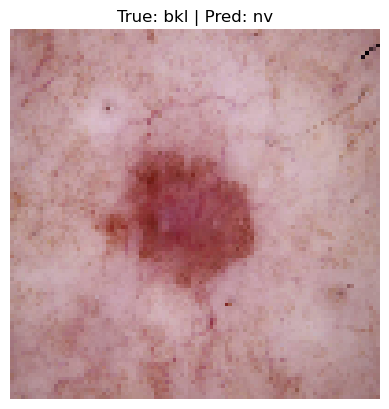

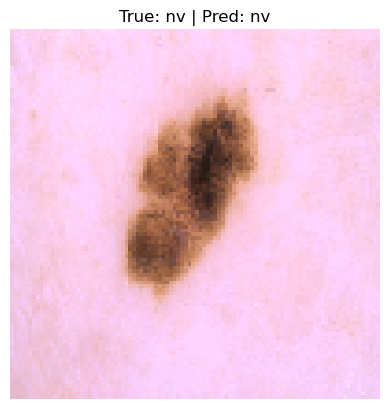

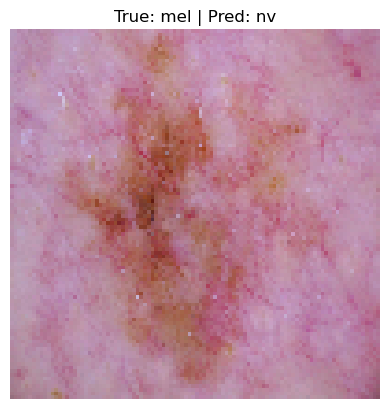

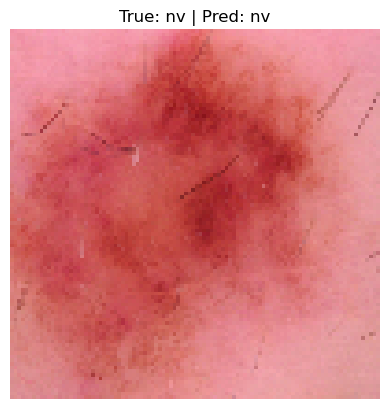

In [13]:
#visualize predictions

import random

indices = random.sample(range(len(X_test)), 5)

for i in indices:
    img = X_test[i]
    true_label = label_encoder.inverse_transform([np.argmax(y_test[i])])[0]
    pred_label = label_encoder.inverse_transform([np.argmax(y_pred_probs[i])])[0]

    plt.imshow(img)
    plt.title(f"True: {true_label} | Pred: {pred_label}")
    plt.axis('off')
    plt.show()


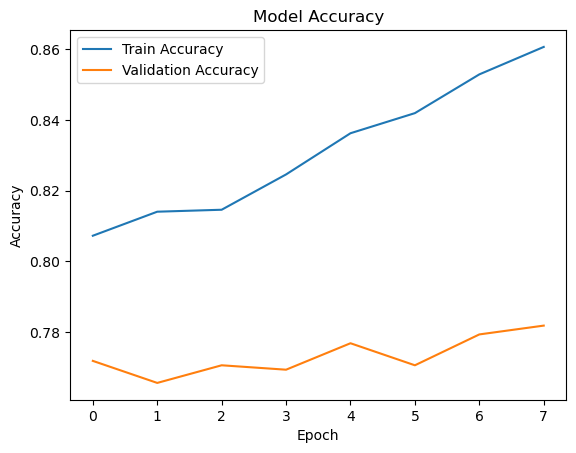

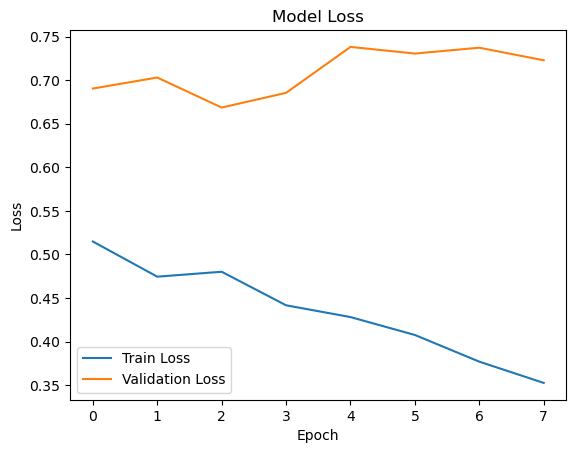

In [14]:
import matplotlib.pyplot as plt

# Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
final_train_acc = history.history['accuracy'][-1]
print(f"Final training accuracy: {final_train_acc:.4f}")


Final training accuracy: 0.8606
